In [1]:
# Enable automatic import reloading
%load_ext autoreload
%autoreload 2

# Display outputs from all lines when they exist
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # "last"

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import triadicsim

In [12]:
import os
import pickle

In [9]:
def get_filename(graph_type, closure_method, experiment_type, value, ):
    return f'e1_hyperparam/{graph_type}_model{closure_method}_{experiment_type}{value}.pkl'


In [48]:
graph_type = "gnp"
closure_methods= ['pop', 'static', 'random', 'max', ]
experiment_types = ['closure', 'threshold']
threshold_vals = np.arange(0.1, 1, 0.1)
closure_vals = [1, 5, 10, 15, 20, 25]



In [51]:
import pandas as pd

In [59]:
all_data = pd.DataFrame(columns=['max_size_rounds', 'rounds_filled', 'max_sizes', 'graph_type', 'closure_method', 'experiment_type', 'values'])

In [62]:
for i, closure_method in enumerate(closure_methods):
    
    all_max_size_rounds = []
    for closure_val in closure_vals:
        filename = get_filename(graph_type, closure_method, "closure", closure_val)
        (sim_log, rounds_filled, rounds_frozen, max_size_round, sizes_round) = pickle.load(
            open(filename, 'rb')
        )
        all_max_size_rounds.append(max_size_round)
        
        vals = {
            'max_size_rounds': np.array(max_size_round),
            'rounds_filled': np.array(rounds_filled),
            'max_sizes': np.array([max(x) for x in sizes_round]),
            'graph_type': graph_type,
            'closure_method': closure_method, 
            'experiment_type': "closure", 
            'values': closure_val
        }
        all_data = all_data.append(vals, ignore_index=True)



In [67]:
def filter_df(df, filter_d):
    for k, v in filter_d.items():
        df = df[df[k] == v]
    return df

In [71]:
df = filter_df(all_data, {            'graph_type': graph_type,
            'closure_method': closure_method, 
            'experiment_type': "closure",})
df.head()

,max_size_rounds,rounds_filled,max_sizes,graph_type,closure_method,experiment_type,values
18,"[28, 20, 4, 17, 100, 16, 3, 12, 3, 13, 22, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0.97, 0.97, 0.13, 0.2, 0.7, 0.97, 0.07, 0.39,...",gnp,max,closure,1
19,"[51, 16, 21, 7, 21, 15, 14, 2, 52, 15, 16, 1, ...","[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...","[0.99, 1.0, 1.0, 1.0, 0.98, 0.98, 0.99, 0.07, ...",gnp,max,closure,5
20,"[81, 17, 29, 23, 85, 90, 53, 14, 12, 36, 100, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...","[0.09, 1.0, 1.0, 0.96, 0.13, 0.3, 0.2, 0.18, 0...",gnp,max,closure,10
21,"[18, 17, 51, 17, 26, 62, 100, 11, 83, 28, 38, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.97, 0.99, 0.95, 1.0, 1.0, 0.99, 0.56, 0.99,...",gnp,max,closure,15
22,"[27, 18, 18, 30, 10, 37, 60, 36, 28, 14, 38, 2...","[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[1.0, 1.0, 1.0, 0.99, 1.0, 0.07, 0.99, 0.99, 0...",gnp,max,closure,20


/var/folders/cg/yfyy6nkx6jd8r_wqrhbygzkh0000gn/T/ipykernel_59365/2363630526.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(x) for x in closure_vals]);


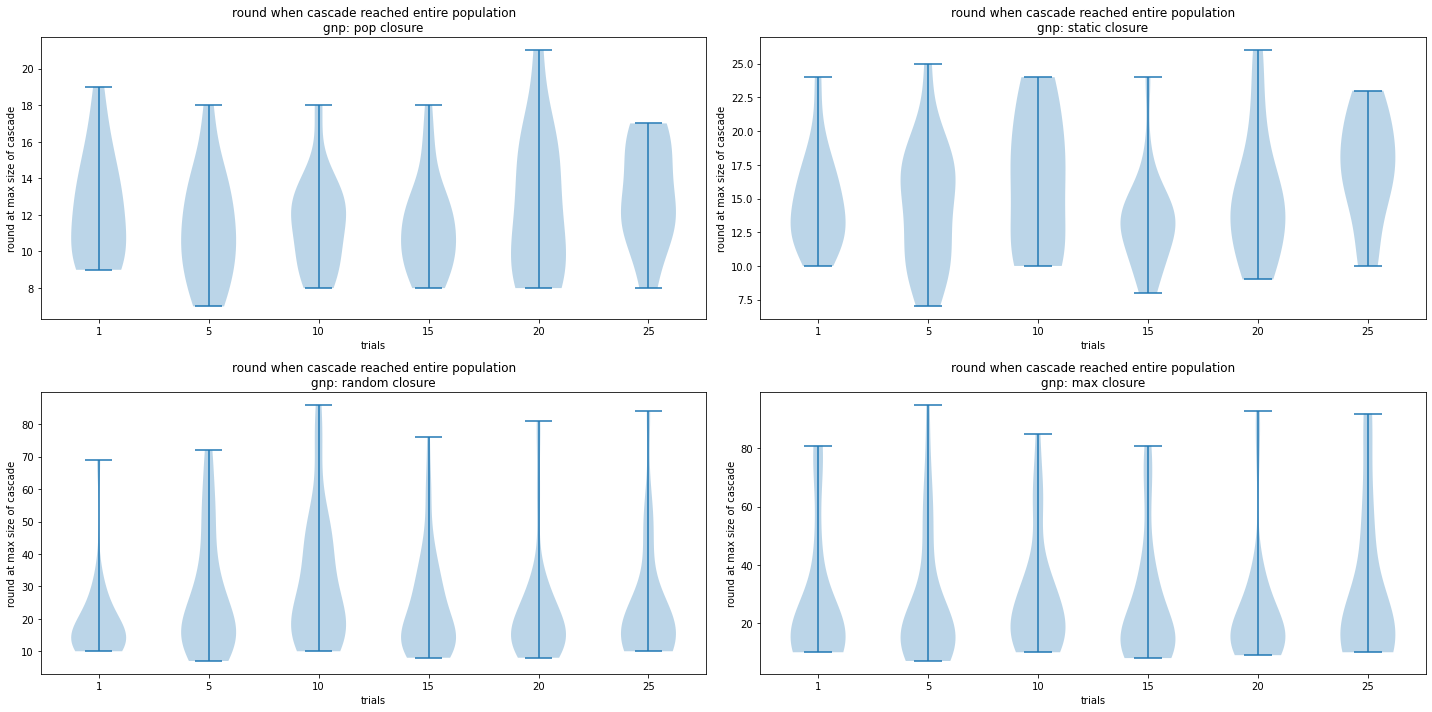

In [109]:
f, axs = plt.subplots(2, 2, figsize=(20, 10))
PLOT_TYPE= 'violin' # 'hist', 'violin', 'box'

for i, closure_method in enumerate(closure_methods):
    ax = axs[i//2, i%2]
    
    df = filter_df(all_data, {'graph_type': graph_type,
            'closure_method': closure_method, 
            'experiment_type': "closure"})
    
    if PLOT_TYPE != 'hist':
        all_round_when_complete = []
    for i, row in df.iterrows():
        round_when_complete = [max_size_round for (filled, max_size_round) in zip(row['rounds_filled'], row['max_size_rounds']) if filled]        
        assert len(round_when_complete) == np.sum(row['rounds_filled'])
        if PLOT_TYPE == 'hist':
            ax.hist(round_when_complete, label=row['values'], alpha=0.5);
        else:
            all_round_when_complete.append(round_when_complete)
    if PLOT_TYPE == 'violin':
        ax.violinplot(all_round_when_complete)
    elif PLOT_TYPE == 'box':
        ax.boxplot(all_round_when_complete)
        
    if PLOT_TYPE == 'hist':
        ax.legend(loc='upper right');
        ax.set_xlabel('round at max size of cascade');
        ax.set_ylabel('trials');

    elif PLOT_TYPE == 'violin':
        ax.set_xticklabels([''] + [str(x) for x in closure_vals]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('number of added edges per round');
    elif PLOT_TYPE == 'box':
        ax.set_xticklabels([str(x) for x in closure_vals]);
        ax.set_ylabel('round at max size of cascade');
        ax.set_xlabel('number of added edges per round');
        
    ax.set_ylabel('round at max size of cascade');
    ax.set_xlabel('trials');
    ax.set_title(f"round when cascade reached entire population\n{graph_type}: {closure_method} closure");
f.tight_layout();
